In [ ]:
import pandas as pd
import numpy as np
import joblib
import statistics
from scipy.stats import entropy
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import CubicSpline

In [54]:
train_data = pd.read_parquet('train_data.parquet')
test_data = pd.read_parquet('test_data.parquet')

In [55]:
train_data.shape

(178340, 97)

In [56]:
# Combine call and put IV columns for train_data
iv_columns = [col for col in train_data.columns if col.startswith("call_iv") or col.startswith("put_iv")]

# Create a mask: True where all IVs are between 0 and 5 (inclusive)
iv_data = train_data[iv_columns]
iv_mask = (iv_data >= 0) & (iv_data <= 5)
iv_mask = iv_mask.all(axis=1)
# Filter the train_data using the mask
filtered_train_data = train_data[iv_mask].copy()

In [57]:
# Convert 'timestamp' to datetime
filtered_train_data['timestamp_dt'] = pd.to_datetime(filtered_train_data['timestamp'])

# Combine 'expiry' with expiry time '15:30:00'(assuming Indian stock market closing time) and convert to datetime
filtered_train_data['expiry_dt'] = pd.to_datetime(filtered_train_data['expiry'].astype(str) + ' 15:30:00')
# Calculate time to expiration in years
filtered_train_data['time_to_expiry'] = (filtered_train_data['expiry_dt'] - filtered_train_data['timestamp_dt']).dt.total_seconds() / (365.25 * 24 * 3600)

# Drop the original 'timestamp' and 'expiry' columns
filtered_train_data = filtered_train_data.drop(['timestamp', 'expiry', 'timestamp_dt', 'expiry_dt'], axis=1)

In [69]:
max(filtered_train_data['time_to_expiry'])

0.017738991558293407

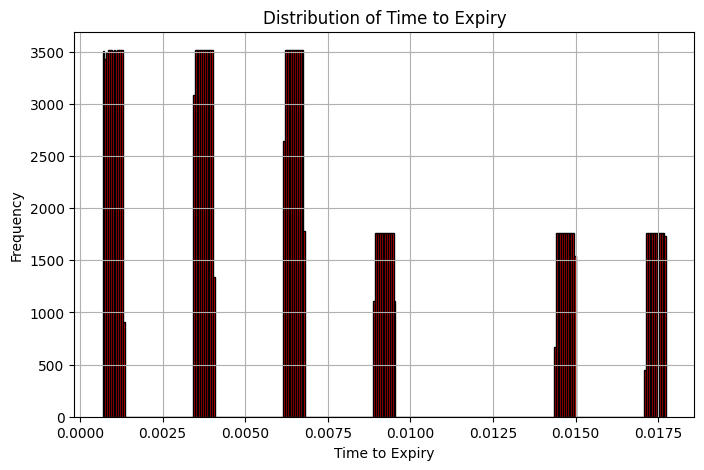

In [ ]:
plt.figure(figsize=(8, 5))
# dividing time to expiry(TTE) into bins where each bin represent 0.5 hr as max TTE is approx. 0.0177
plt.hist(filtered_train_data["time_to_expiry"], bins=306, color='red', edgecolor='black')
plt.title("Distribution of Time to Expiry")
plt.xlabel("Time to Expiry")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


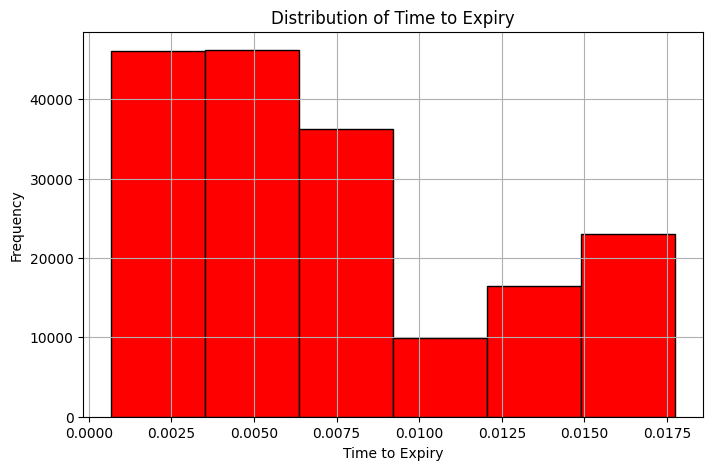

In [71]:
# There are broadly 6 intervals for TTE, therefore dividing into 6 bins
plt.figure(figsize=(8, 5))
plt.hist(filtered_train_data["time_to_expiry"], bins=6, color='red', edgecolor='black')
plt.title("Distribution of Time to Expiry")
plt.xlabel("Time to Expiry")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [73]:
counts, bin_edges = np.histogram(filtered_train_data["time_to_expiry"], bins=6)

# Display the 6 intervals
intervals = [(bin_edges[i], bin_edges[i+1]) for i in range(len(bin_edges) - 1)]
print("6 Broad Intervals:")
for idx, interval in enumerate(intervals):
    print(f"Interval {idx + 1}: {interval[0]:.6f} to {interval[1]:.6f}")


6 Broad Intervals:
Interval 1: 0.000684 to 0.003527
Interval 2: 0.003527 to 0.006369
Interval 3: 0.006369 to 0.009212
Interval 4: 0.009212 to 0.012054
Interval 5: 0.012054 to 0.014897
Interval 6: 0.014897 to 0.017739


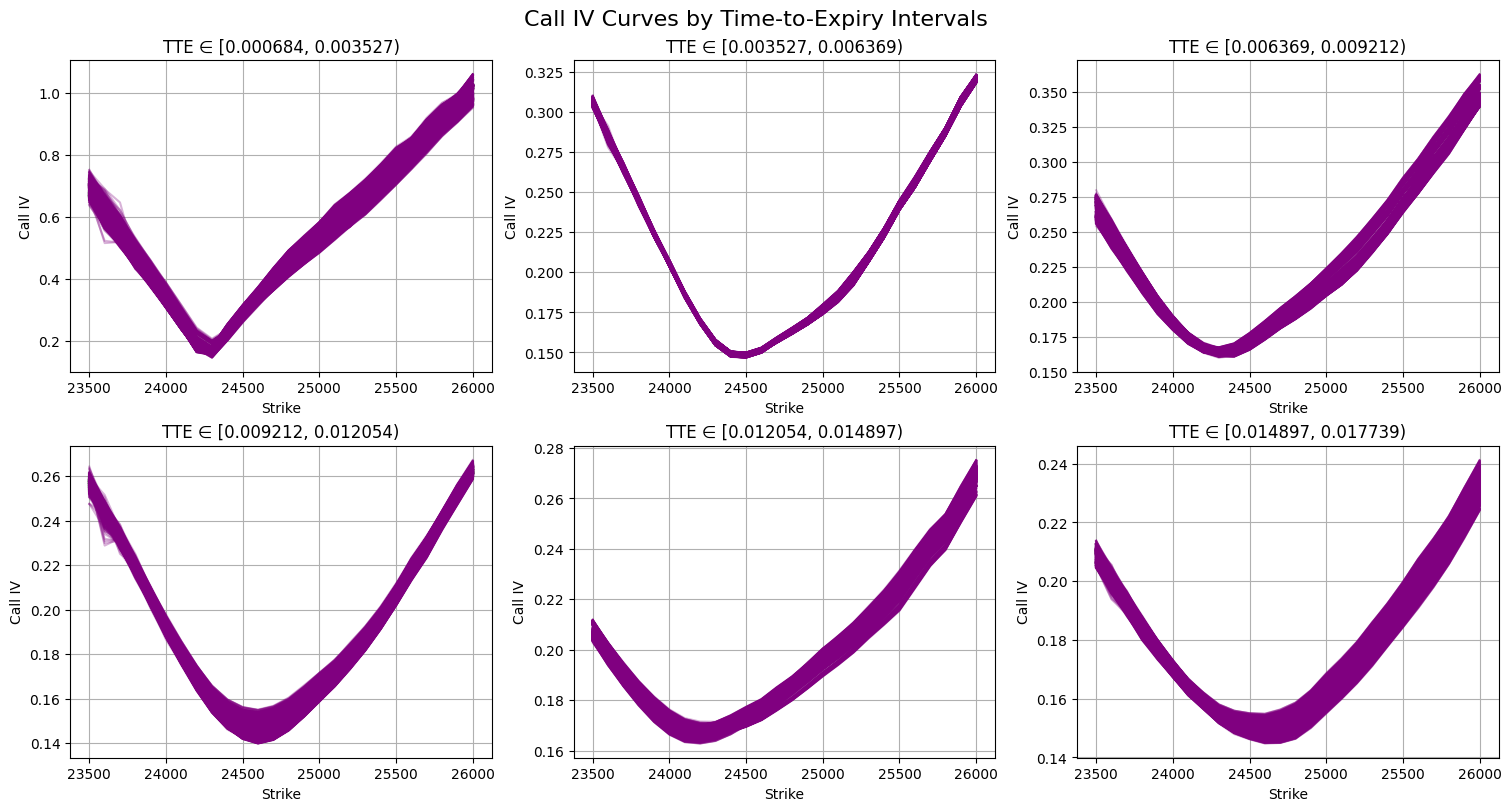

In [ ]:
# Step 1: Define intervals
n_intervals = 6
counts, bin_edges = np.histogram(filtered_train_data["time_to_expiry"], bins=n_intervals)

call_iv_cols = [col for col in filtered_train_data.columns if col.startswith('call_iv')]
call_strikes = [float(col.split('_')[-1]) for col in call_iv_cols]
call_iv_matrix = filtered_train_data[call_iv_cols].values
time_to_expiry = filtered_train_data["time_to_expiry"].values

# Subplot grid
n_cols = 3
n_rows = (n_intervals + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), constrained_layout=True)

for i in range(n_intervals):
    start, end = bin_edges[i], bin_edges[i+1]
    mask = (time_to_expiry >= start) & (time_to_expiry < end)
    group = call_iv_matrix[mask]
    group = group[:1000]

    ax = axes[i // n_cols, i % n_cols]  # get subplot
    if group.shape[0] > 0:
        ax.plot(call_strikes, group.T, color='purple', alpha=0.3)
    ax.set_title(f"TTE ∈ [{start:.6f}, {end:.6f})")
    ax.set_xlabel("Strike")
    ax.set_ylabel("Call IV")
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.suptitle("Call IV Curves by Time-to-Expiry Intervals", fontsize=16)
plt.show()


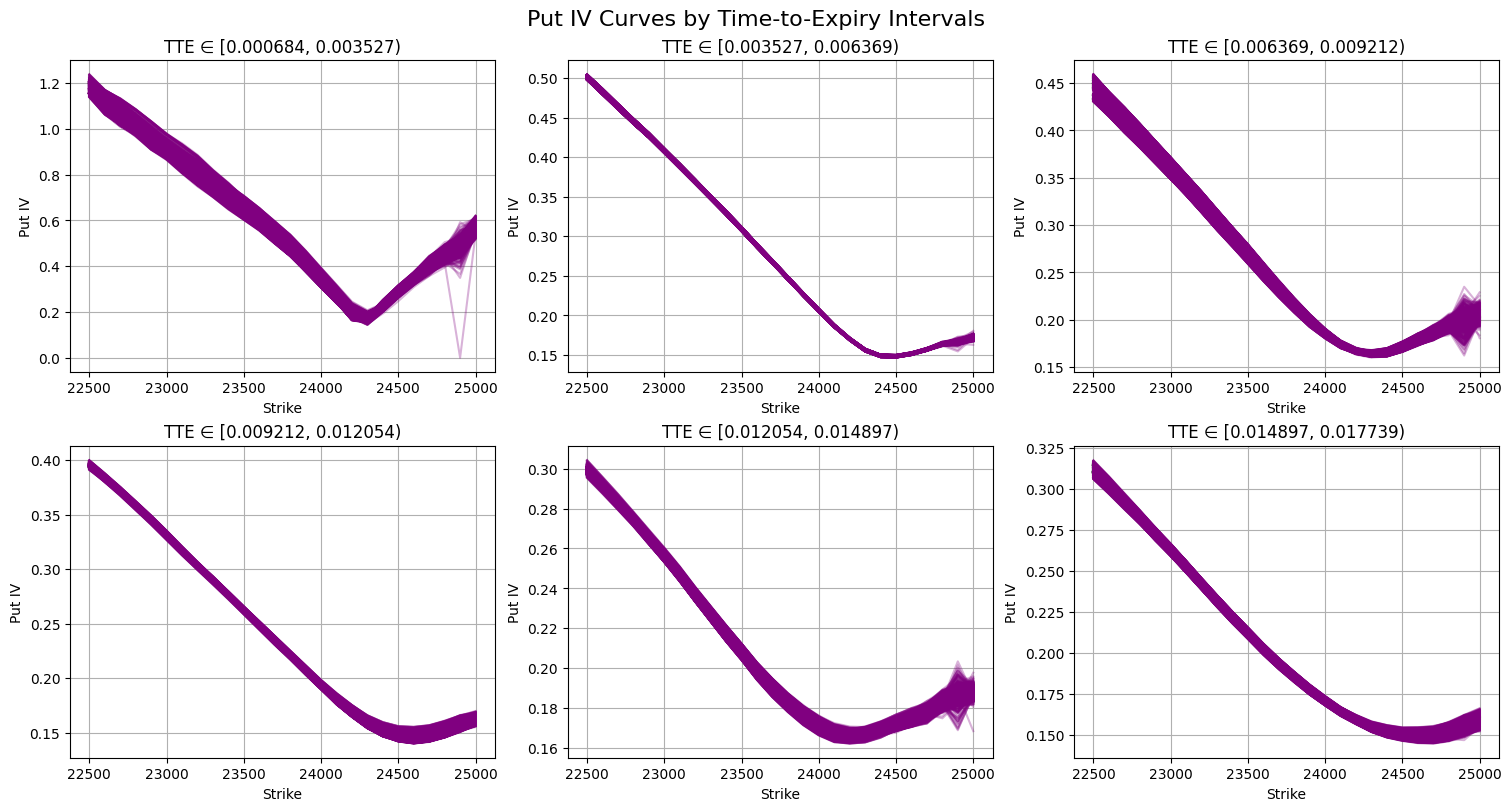

In [87]:
put_ivs = [col for col in filtered_train_data.columns if col.startswith('put_iv')]
put_strikes = [float(col.split('_')[-1]) for col in put_ivs]
put_strikes = np.array(put_strikes)

# Convert put_iv values to NumPy array
put_iv_matrix = filtered_train_data[put_ivs].values
time_to_expiry = filtered_train_data["time_to_expiry"].values

# Subplot grid
n_cols = 3
n_rows = (n_intervals + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), constrained_layout=True)

for i in range(n_intervals):
    start, end = bin_edges[i], bin_edges[i+1]
    mask = (time_to_expiry >= start) & (time_to_expiry < end)
    group = put_iv_matrix[mask]
    group = group[:1000]

    ax = axes[i // n_cols, i % n_cols]  # get subplot
    if group.shape[0] > 0:
        ax.plot(put_strikes, group.T, color='purple', alpha=0.3)
    ax.set_title(f"TTE ∈ [{start:.6f}, {end:.6f})")
    ax.set_xlabel("Strike")
    ax.set_ylabel("Put IV")
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.suptitle("Put IV Curves by Time-to-Expiry Intervals", fontsize=16)
plt.show()


*From these graphs it can be inferred that smile curves are highly dependent on time to expiry and can be broadly classified in 6 types based on time to expiry. Thus predicting time to expiry could be very useful in predicting IVs.*

# Predicting TTE(Time to expiry) for test data

*As Xs are proprietary variables, TTE is independant of them, and while calculating IVs from Black Scholes Formula TTE is one of the variables required thus IVs and shape of smile curve depends on TTE a lot. So our next steps will be fitting an approximate curve on the known test data just to get approximate curve shape and use this data to classify the TTE in above 6 categories, here I will just be considering call IVs to predict TTEs for test data, we can also use put IVs, both should give same result.*

Training a XGBoost regressor on train data with target column as TTE.

In [90]:
call_iv_cols_test = [col for col in test_data.columns if col.startswith('call_iv')]
put_iv_cols_test = [col for col in test_data.columns if col.startswith('put_iv')]

In [157]:
common_call_ivs = list(set(call_iv_cols) & set(call_iv_cols_test))

X_tte = filtered_train_data[['underlying'] + common_call_ivs]
y_tte = filtered_train_data['time_to_expiry']

# Scale features
scaler_TTE_call = StandardScaler()
X_scaled = scaler_TTE_call.fit_transform(X_tte)

xgb_TTE_call = XGBRegressor(n_estimators=200, max_depth=15, n_jobs=-1, random_state=42)
xgb_TTE_call.fit(X_scaled, y_tte)
y_pred = xgb_TTE_call.predict(X_scaled)
print("Mean squared error (XGB):", np.mean((y_tte - y_pred)**2))


Mean squared error (XGB): 4.89688995115618e-10


Fitting a cubic spline on call IVs in test data

In [151]:
test_data.shape, ((~test_data[call_iv_cols_test].isna()).sum(axis = 1) >= 2).sum(), ((~test_data[call_iv_cols_test].isna()).sum(axis = 1) >= 3).sum()

((12065, 96), 12065, 12064)

There are atleast 2 known call IV values in each row of test data so we will fit a 2 degree polynomial.

In [145]:
test_data_poly_fitted = test_data.copy()

In [146]:
strikes_call_test = np.array([float(col.split('_')[-1]) for col in call_iv_cols_test])
strikes_put_test = np.array([float(col.split('_')[-1]) for col in put_iv_cols_test])

for i, row in tqdm(test_data_poly_fitted.iterrows(), total=len(test_data_poly_fitted)):
    # ----- Call side -----
    call_ivs = row[call_iv_cols_test].values.astype(float)
    mask = ~row[call_iv_cols_test].isna()
    known_strikes = strikes_call_test[mask]
    known_ivs = row[call_iv_cols_test][mask].values
    if (~np.isnan(known_ivs)).sum() >= 2:
        coeffs_call = np.polyfit(known_strikes, known_ivs, deg=2)
        poly_call = np.poly1d(coeffs_call)
        smoothed_call_ivs = poly_call(strikes_call_test)
        test_data_poly_fitted.loc[i, call_iv_cols_test] = smoothed_call_ivs


 52%|█████▏    | 6251/12065 [00:21<00:18, 321.37it/s]c:\Users\croma\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 12065/12065 [00:40<00:00, 299.69it/s]


In [148]:
call_iv_test_matrix = test_data_poly_fitted[call_iv_cols_test].values

In [ ]:
((test_data_poly_fitted[call_iv_cols_test] < 0)).sum().sum()

15

In [159]:
X_pred = test_data_poly_fitted[['underlying'] + common_call_ivs]
X_pred_scaled = scaler_TTE_call.transform(X_pred)
y_pred = xgb_TTE_call.predict(X_pred_scaled)

In [ ]:
test_data['time_to_expiry'] = y_pred, test_data_poly_fitted['time_to_expiry'] = y_pred

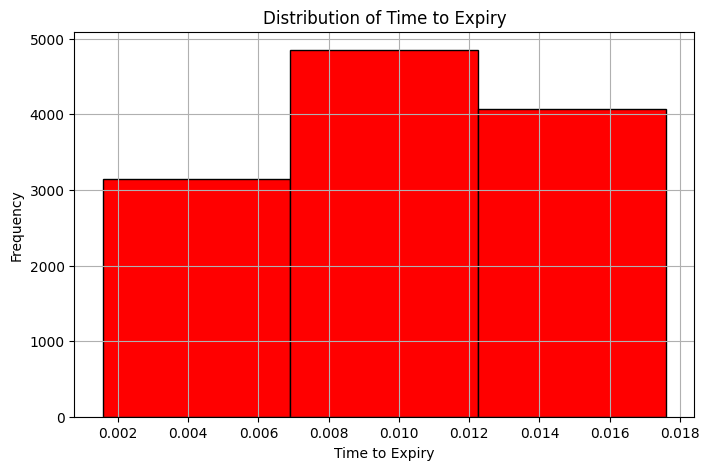

In [167]:
# There are broadly 6 intervals for TTE, therefore dividing into 6 bins
plt.figure(figsize=(8, 5))
plt.hist(test_data_poly_fitted["time_to_expiry"], bins=3, color='red', edgecolor='black')
plt.title("Distribution of Time to Expiry")
plt.xlabel("Time to Expiry")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Broadly time to expiry of test data is distributed in 3 bins.

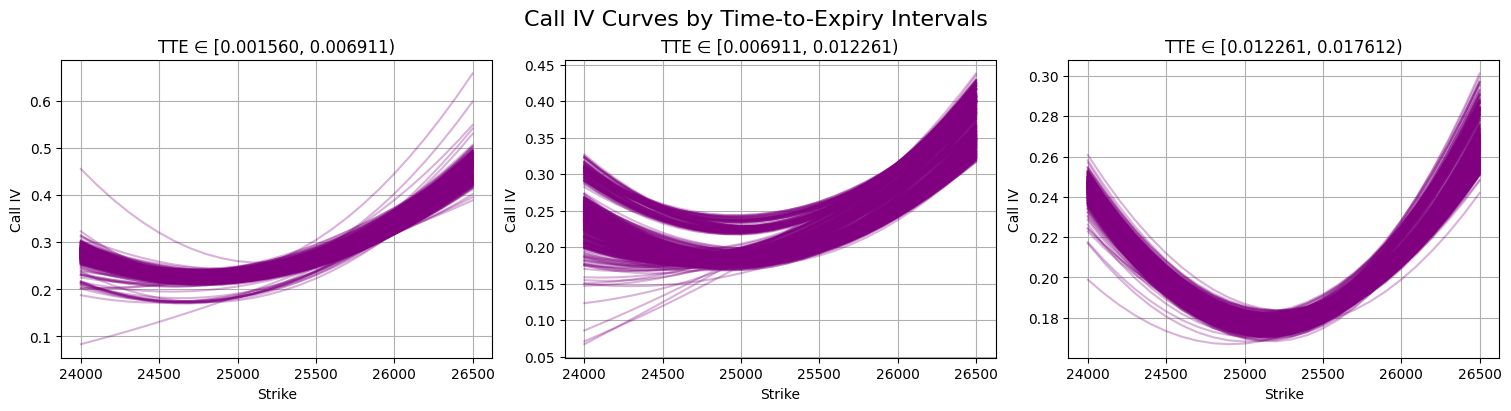

In [ ]:
# Step 1: Define intervals
n_intervals = 3
counts, bin_edges = np.histogram(test_data_poly_fitted["time_to_expiry"], bins=n_intervals)

call_iv_cols = [col for col in test_data_poly_fitted.columns if col.startswith('call_iv')]
call_strikes = [float(col.split('_')[-1]) for col in call_iv_cols]
call_iv_matrix = test_data_poly_fitted[call_iv_cols].values
time_to_expiry = test_data_poly_fitted["time_to_expiry"].values

# Subplot grid
n_cols = 3
n_rows = (n_intervals + n_cols - 1) // n_cols  # = 1 if n_intervals <= n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4), constrained_layout=True)

# Flatten axes for easier iteration if 1D
axes = axes.flatten() if n_intervals == 1 else axes.reshape(-1)

for i in range(n_intervals):
    start, end = bin_edges[i], bin_edges[i+1]
    mask = (time_to_expiry >= start) & (time_to_expiry < end)
    group = call_iv_matrix[mask][150:700]  # Limit to 1000 rows max for clarity

    ax = axes[i]
    if group.shape[0] > 0:
        ax.plot(call_strikes, group.T, color='purple', alpha=0.3)
    ax.set_title(f"TTE ∈ [{start:.6f}, {end:.6f})")
    ax.set_xlabel("Strike")
    ax.set_ylabel("Call IV")
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.suptitle("Call IV Curves by Time-to-Expiry Intervals", fontsize=16)
plt.show()


# Training XGBregressor for predicting IVs trained on test data, features will be- underlying, strike, time to expiry, X{0....41} mean, std and entropy.

In [177]:
store_test_data= test_data.copy()

Calculating entropy, standard deviation, mean for each X{0...41} by grouping TTE in 3 bins.

In [ ]:
from scipy.stats import entropy

# Bin tte into intervals
test_data['tte_bin'] = pd.cut(test_data['time_to_expiry'], bins=3)

# Calculate entropy, mean, std of X0 to X41 for each bin and map to test_data
for i in range(42):
    col = f'X{i}'
    if col in test_data.columns:
        entropy_by_bin = (
            test_data.groupby('tte_bin')[col]
            .apply(lambda x: entropy(np.histogram(x, bins=30, density=True)[0] + 1e-9))
        )
        std_by_bin = (
            test_data.groupby('tte_bin')[col]
            .std()
        )
        mean_by_bin = (
            test_data.groupby('tte_bin')[col]
            .mean()
        )
        test_data[f'{col}_std'] = test_data['tte_bin'].map(std_by_bin)
        test_data[f'{col}_mean'] = test_data['tte_bin'].map(mean_by_bin)
        test_data[f'{col}_entropy'] = test_data['tte_bin'].map(entropy_by_bin)


In [ ]:
# Drop all original X columns from test_data adn tte_bin column
og_x_cols = [col for col in test_data.columns if col.startswith('X') and not(col.endswith('entropy') or col.endswith('centered') or col.endswith('std'))]
test_data = test_data.drop(columns=og_x_cols+['tte_bin'])

*Now we need to make strike as a new feature, thus I will convert test_data from wide to long format
In this process as there are many  IVs(call and put) which are to be predicted so after conversion, we will drop those rows which have these to be predicted values.* 

In [187]:
# For call IVs
call_df = test_data.copy()
call_df['id'] = call_df.index
call_long = pd.wide_to_long(
    call_df,
    stubnames='call_iv',
    i='id',
    j='strike',
    sep='_'
).reset_index()
call_long = call_long.rename(columns={'call_iv': 'call_IV'})
call_long['strike'] = call_long['strike'].astype(float)

# Select only X columns, timestamp, time_to_expiry, underlying, strike, call_IV and drop those rows which have IVs to be predicted
x_cols = [col for col in call_long.columns if col.startswith('X')]
call_melt = call_long[['time_to_expiry', 'underlying', 'strike', 'call_IV'] + x_cols].dropna(subset=['call_IV'])

# For put IVs
put_df = test_data.copy()
put_df['id'] = put_df.index
put_long = pd.wide_to_long(
    put_df,
    stubnames='put_iv',
    i='id',
    j='strike',
    sep='_'
).reset_index()
put_long = put_long.rename(columns={'put_iv': 'put_IV'})
put_long['strike'] = put_long['strike'].astype(float)

# Select only X columns, timestamp, time_to_expiry, underlying, strike, put_IV and drop those rows which have IVs to be predicted
put_melt = put_long[['time_to_expiry', 'underlying', 'strike', 'put_IV'] + x_cols].dropna(subset=['put_IV'])

In [188]:
call_melt.head()

,time_to_expiry,underlying,strike,call_IV,X32_entropy,X22_std,X24_std,X20_std,X41_entropy,X31_entropy,...,X19_std,X9_entropy,X14_entropy,X13_entropy,X3_entropy,X36_entropy,X29_std,X17_entropy,X36_std,X37_entropy
0,0.001626,24735.9,24000.0,0.280939,2.634922,1.148600e+06,0.073446,64727.711147,1.911008,2.498777,...,0.117305,0.241768,2.320959,1.225138,2.412065,2.142865,386736.709642,2.341874,0.038659,2.238885
1,0.001626,24766.7,24000.0,0.270276,2.634922,1.148600e+06,0.073446,64727.711147,1.911008,2.498777,...,0.117305,0.241768,2.320959,1.225138,2.412065,2.142865,386736.709642,2.341874,0.038659,2.238885
3,0.009531,24898.1,24000.0,0.241888,2.686275,1.290789e+06,0.069967,114956.582521,2.067890,2.168043,...,0.109590,0.196401,2.265966,1.300516,2.274372,1.782899,466782.145656,2.299443,0.043636,1.981231
4,0.014986,24906.5,24000.0,0.235328,2.788373,1.146716e+06,0.067390,89527.693270,1.893899,2.679573,...,0.103932,0.212752,2.374024,1.293388,2.224108,2.094962,575202.418573,2.582042,0.037270,2.137331
7,0.001656,24830.0,24000.0,0.275760,2.634922,1.148600e+06,0.073446,64727.711147,1.911008,2.498777,...,0.117305,0.241768,2.320959,1.225138,2.412065,2.142865,386736.709642,2.341874,0.038659,2.238885


Scaling Data

In [197]:
X_call = call_melt[['time_to_expiry', 'underlying', 'strike'] + x_cols]
y_call = call_melt['call_IV']
X_put = put_melt[['time_to_expiry', 'underlying', 'strike'] + x_cols]
y_put = put_melt['put_IV']

scaler_call_iv = StandardScaler()
scaler_put_iv = StandardScaler()

X_call_scaled = scaler_call_iv.fit_transform(X_call)
X_put_scaled = scaler_put_iv.fit_transform(X_put)

Now training model for call IVs

In [198]:
xgb_call = XGBRegressor(n_estimators=200, max_depth=15, n_jobs=-1, random_state=42)
xgb_call.fit(X_call_scaled, y_call)
y_pred = xgb_call.predict(X_call_scaled)
print("Mean squared error (XGB):", np.mean((y_pred - y_call)**2))

Mean squared error (XGB): 7.683293141436119e-06


Now training model for Put IVs

In [199]:
xgb_put = XGBRegressor(n_estimators=200, max_depth=15, n_jobs=-1, random_state=42)
xgb_put.fit(X_put_scaled, y_put)
y_pred = xgb_put.predict(X_put_scaled)
print("Mean squared error (XGB):", np.mean((y_pred - y_put)**2))

Mean squared error (XGB): 6.6727690995920994e-06


In [201]:
predicting_columns = ['time_to_expiry', 'underlying', 'strike'] + x_cols

In [202]:
# Identify call and put IV columns in test_data
call_iv_cols_test = [col for col in test_data.columns if col.startswith('call_iv_')]
put_iv_cols_test = [col for col in test_data.columns if col.startswith('put_iv_')]

# Predict missing call IVs
for col in call_iv_cols_test:
    missing_mask = test_data[col].isnull()
    if missing_mask.any():
        strike = float(col.split('_')[-1])
        X_pred = pd.DataFrame({
            'time_to_expiry':test_data.loc[missing_mask, 'time_to_expiry'],
            'underlying': test_data.loc[missing_mask, 'underlying'],
            'strike': strike
        })
        # Add entropy, std and mean features
        for feat in x_cols:
            X_pred[feat] = test_data.loc[missing_mask, feat].values
        X_pred = X_pred.reindex(columns=predicting_columns)
        X_pred_scaled = scaler_call_iv.transform(X_pred)
        test_data.loc[missing_mask, col] = xgb_call.predict(X_pred_scaled)

# Predict missing put IVs
for col in put_iv_cols_test:
    missing_mask = test_data[col].isnull()
    if missing_mask.any():
        strike = float(col.split('_')[-1])
        X_pred = pd.DataFrame({
            'time_to_expiry':test_data.loc[missing_mask, 'time_to_expiry'],
            'underlying': test_data.loc[missing_mask, 'underlying'],
            'strike': strike
        })
        # Add entropy, std and mean features
        for feat in x_cols:
            X_pred[feat] = test_data.loc[missing_mask, feat].values
        X_pred = X_pred.reindex(columns=predicting_columns)
        X_pred_scaled = scaler_put_iv.transform(X_pred)
        test_data.loc[missing_mask, col] = xgb_put.predict(X_pred_scaled)

In [206]:
temp_test_data = pd.read_parquet('test_data.parquet')
temp_test_data.fillna(test_data,inplace = True)

In [207]:
sample_submission = pd.read_csv('sample_submission.csv')
submission = temp_test_data[sample_submission.columns]

In [209]:
submission.to_csv('submission.csv',index=False)